In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, pickle
import datetime as dt

# initialize a connection to the database
import sqlite3
conn = sqlite3.connect('../Spotify_Challenge/dbsql.db')

# initialize another sqlalchemy connection to the same database to be able to query data straight to pandas dataframe
from sqlalchemy import create_engine
disk_engine = create_engine('sqlite:///../Spotify_Challenge/dbsql.db')

from sklearn.preprocessing import Imputer,StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
features = [u'index',u'YEAR', u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK', u'AIRLINE_ID', 
            u'CARRIER', u'TAIL_NUM', u'FL_NUM', u'ORIGIN_AIRPORT_ID', u'ORIGIN', u'ORIGIN_CITY_NAME', 
            u'ORIGIN_STATE_NM', u'DEST_AIRPORT_ID', u'DEST', u'DEST_CITY_NAME', u'DEST_STATE_NM', 
            u'DEP_DELAY', u'DEP_DELAY_NEW', u'DEP_DEL15', u'TAXI_OUT', u'TAXI_IN', u'ARR_DELAY', 
            u'ARR_DELAY_NEW', u'ARR_DEL15', u'CANCELLED', u'CANCELLATION_CODE', u'DIVERTED', u'AIR_TIME', 
            u'FLIGHTS', u'DISTANCE', u'CARRIER_DELAY', u'WEATHER_DELAY', u'NAS_DELAY', u'SECURITY_DELAY', 
            u'LATE_AIRCRAFT_DELAY',u'FL_DATE']
years = (2010,2011,2012,2013,2014,2015)

## Functions

In [79]:
# This method will be used to valuate the goodness of clusters
def se(v1,v2):
    """return the squared error between two vectors v1, v2"""
    return sum((v1-v2)**2)

def calculate_sse(df,centroids,labels):
    """Calculate the sse of instance in dataframe to the centroids"""
    labels = pd.unique(labels).tolist()
    sse = []    
    for l in labels:
        dftmp = df[df.C==c].drop('C',axis=1)
        s = sum(map(lambda x:se(x,centroids[labels.index(l)]),dftmp.values))
        sse.append(s)
    return sum(sse)

def optimize_n_k(df,n_max,k_max, gen_plot=True):
    """optimize number of components and clusters for good clustering"""
    sses = []
    ns = []
    ks = []
    for n in range(1,n_max):
        ns.append(n)
        sse = []
        for k in range(1,k_max):
            ks.append(k)
            pca = PCA(n_components=n)
            pca_data = pd.DataFrame(pca.fit_transform(df))
            km = KMeans(k,random_state=1234)
            km.fit(pca_data)
            centroids = km.cluster_centers_
            labels = km.labels_
            
            cat_data = pca_data.copy()
            cat_data['C'] = labels
            sse.append(calculate_sse(cat_data,centroids,labels))
        sses.append(sse)
    sses = np.array(sses)
    if gen_plot:
        plt.plot(sses.transpose())
        plt.legend(range(1,n_max),loc='best')
        plt.xlabel('k')
        plt.ylabel('SSE')
        plt.title('n_k_optimization')
        plt.show()
    return sses, ns, ks

In [38]:
# load airports data. This is the table containing coordinates of airports
airports = pd.read_sql_query('select iata, lat, long from airports',disk_engine)


# load all data aggregated by origin
tic = dt.datetime.now() #time the process
if 'agg_per_origin' in map(lambda x:x[0],conn.execute("select name from sqlite_master where type = 'table'").fetchall()):
    # load the table if it exists already
    df1 = pd.read_sql_query("SELECT * FROM agg_per_origin",disk_engine)
    if 'index' in df1.columns:
        df1.drop('index',axis=1,inplace=True)
else:
    # otherwise, query data from the database
    print "querying from raw data"
    df1 = pd.read_sql_query("SELECT YEAR, ORIGIN, SUM(FLIGHTS) AS FLIGHTS, SUM(DEP_DEL15) AS DEP_DEL, "
                            "SUM(DEP_DELAY) AS DDEL1, SUM(DEP_DELAY_NEW) AS DDEL2, SUM(CANCELLED) AS CANCELLED, "
                            "SUM(SECURITY_DELAY) AS SEC_DEL, SUM(CARRIER_DELAY) AS CAR_DEL, SUM(NAS_DELAY) AS NAS_DEL, "
                            "SUM(WEATHER_DELAY) AS WEA_DEL, SUM(LATE_AIRCRAFT_DELAY) AS LAD_DEL "
                            "FROM data "
                            "GROUP BY YEAR, ORIGIN",disk_engine)
    #push the aggregated data back to the database
    df1.to_sql('agg_per_origin',conn,index=False)
print dt.datetime.now()-tic #print the time taken for this operation


# load all data aggreagated by destination
tic = dt.datetime.now() #time the process
if 'agg_per_destination' in map(lambda x:x[0],conn.execute("select name from sqlite_master where type = 'table'").fetchall()):
    # load the table if it exists already
    df2 = pd.read_sql_query("SELECT * FROM agg_per_destination",disk_engine)
    if 'index' in df2.columns:
        df2.drop('index',axis=1,inplace=True)
else:
    # otherwise, query data from the database
    print "querying from raw data"
    df2 = pd.read_sql_query("SELECT YEAR, DEST, SUM(FLIGHTS) AS FLIGHTS, SUM(ARR_DEL15) AS ARR_DEL, "
                            "SUM(ARR_DELAY) AS ADEL1, SUM(ARR_DELAY_NEW) AS ADEL2, SUM(DIVERTED) AS DIVERTED "
                            "FROM data "
                            "GROUP BY YEAR, DEST",disk_engine)
    #push the aggregated data back to the database
    df2.to_sql('agg_per_destination',conn,index=False)
print dt.datetime.now()-tic #print the time taken for this operation


# put origin and destination data together
#loop through years and merge data in df1, df2 and airports per year and origin
tmp_df = pd.DataFrame()
for yoi in years:
    agg_df = pd.merge(df1[df1.YEAR == yoi],df2[df2.YEAR == yoi],left_on='ORIGIN',right_on='DEST')

    # append coordinates as well
    agg_df = pd.merge(agg_df,airports,left_on='ORIGIN', right_on='iata')
    agg_df.drop(['DEST','YEAR_y','iata'],axis=1,inplace=True)
    agg_df.rename(columns={'YEAR_x':'YEAR','FLIGHTS_x':'DEP_FLIGHTS','FLIGHTS_y':'ARR_FLIGHTS','ORIGIN':'IATA',
                           'lat':'LAT','long':'LON'}, inplace=True)

    # assign aggregated data to airports
    tmp_df = pd.concat([tmp_df,agg_df],ignore_index=True)

# now let's normalize some features with respect to the number of departure flights 
#features_to_normalize = ['DEP_FLIGHTS','DEP_DEL','DDEL1','DDEL2','CANCELLED','SEC_DE?L','CAR_DEL','NAS_DEL',
#                         'WEA_DEL','LAD_DEL','ARR_FLIGHTS','ARR_DEL','ADEL1','ADEL2','DIVERTED']
#airports = tmp_df[['YEAR','IATA']]
#for col in features_to_normalize:
#    airports[col] = (tmp_df.loc[:,col]/tmp_df['DEP_FLIGHTS']).values
data = tmp_df.copy()
#airports = airports_all[(airports_all.YEAR >= 2010)|(airports_all.YEAR <= 2015)]
#data = data.groupby('IATA').mean().reset_index()

0:00:00.014995
0:00:00.013630


## Data Cleaning


In [39]:
numeric_features = ['DEP_FLIGHTS', u'DEP_DEL', u'DDEL1', u'DDEL2', u'CANCELLED', u'SEC_DEL', u'CAR_DEL', 
                    u'NAS_DEL', u'WEA_DEL', u'LAD_DEL', 'ARR_FLIGHTS', u'ARR_DEL', u'ADEL1', u'ADEL2', u'DIVERTED']
categorical_features = ['YEAR', 'IATA']
coord_features = ['LAT', 'LON']

# impute missing values
print "imputing NA ..."
imputer = Imputer(strategy='most_frequent')
data[numeric_features] = imputer.fit_transform(data[numeric_features])

# create new features
print "creating new features ..."
data['REC_TIME'] = data.DDEL2 - data.ADEL2
numeric_features.append('REC_TIME')

# normalize with respect to departure flights
print "normalizing with respect to number of dep flights ..."
features_norm = numeric_features[1:]
data[features_norm] = (data[features_norm].T/data['DEP_FLIGHTS']).T.values
print "done"

imputing NA ...
creating new features ...
normalizing with respect to number of dep flights ...
done


## Data Exploration

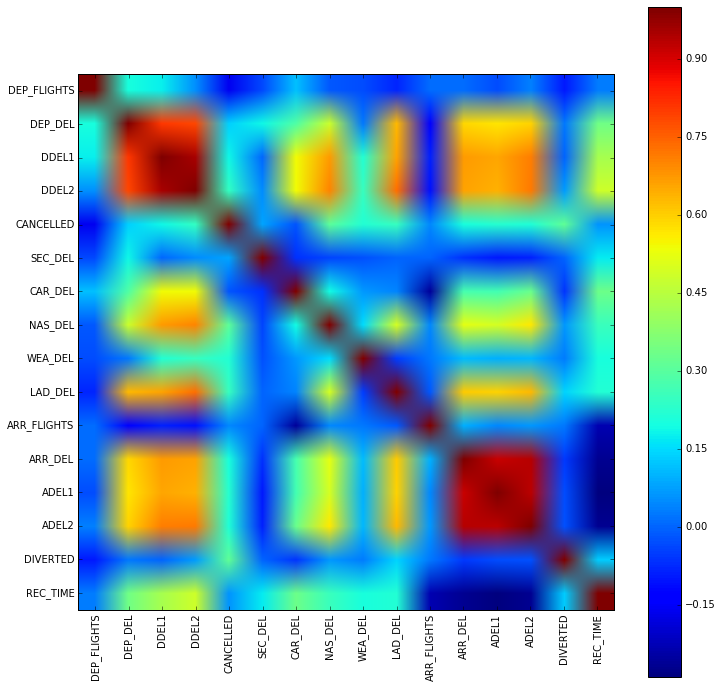

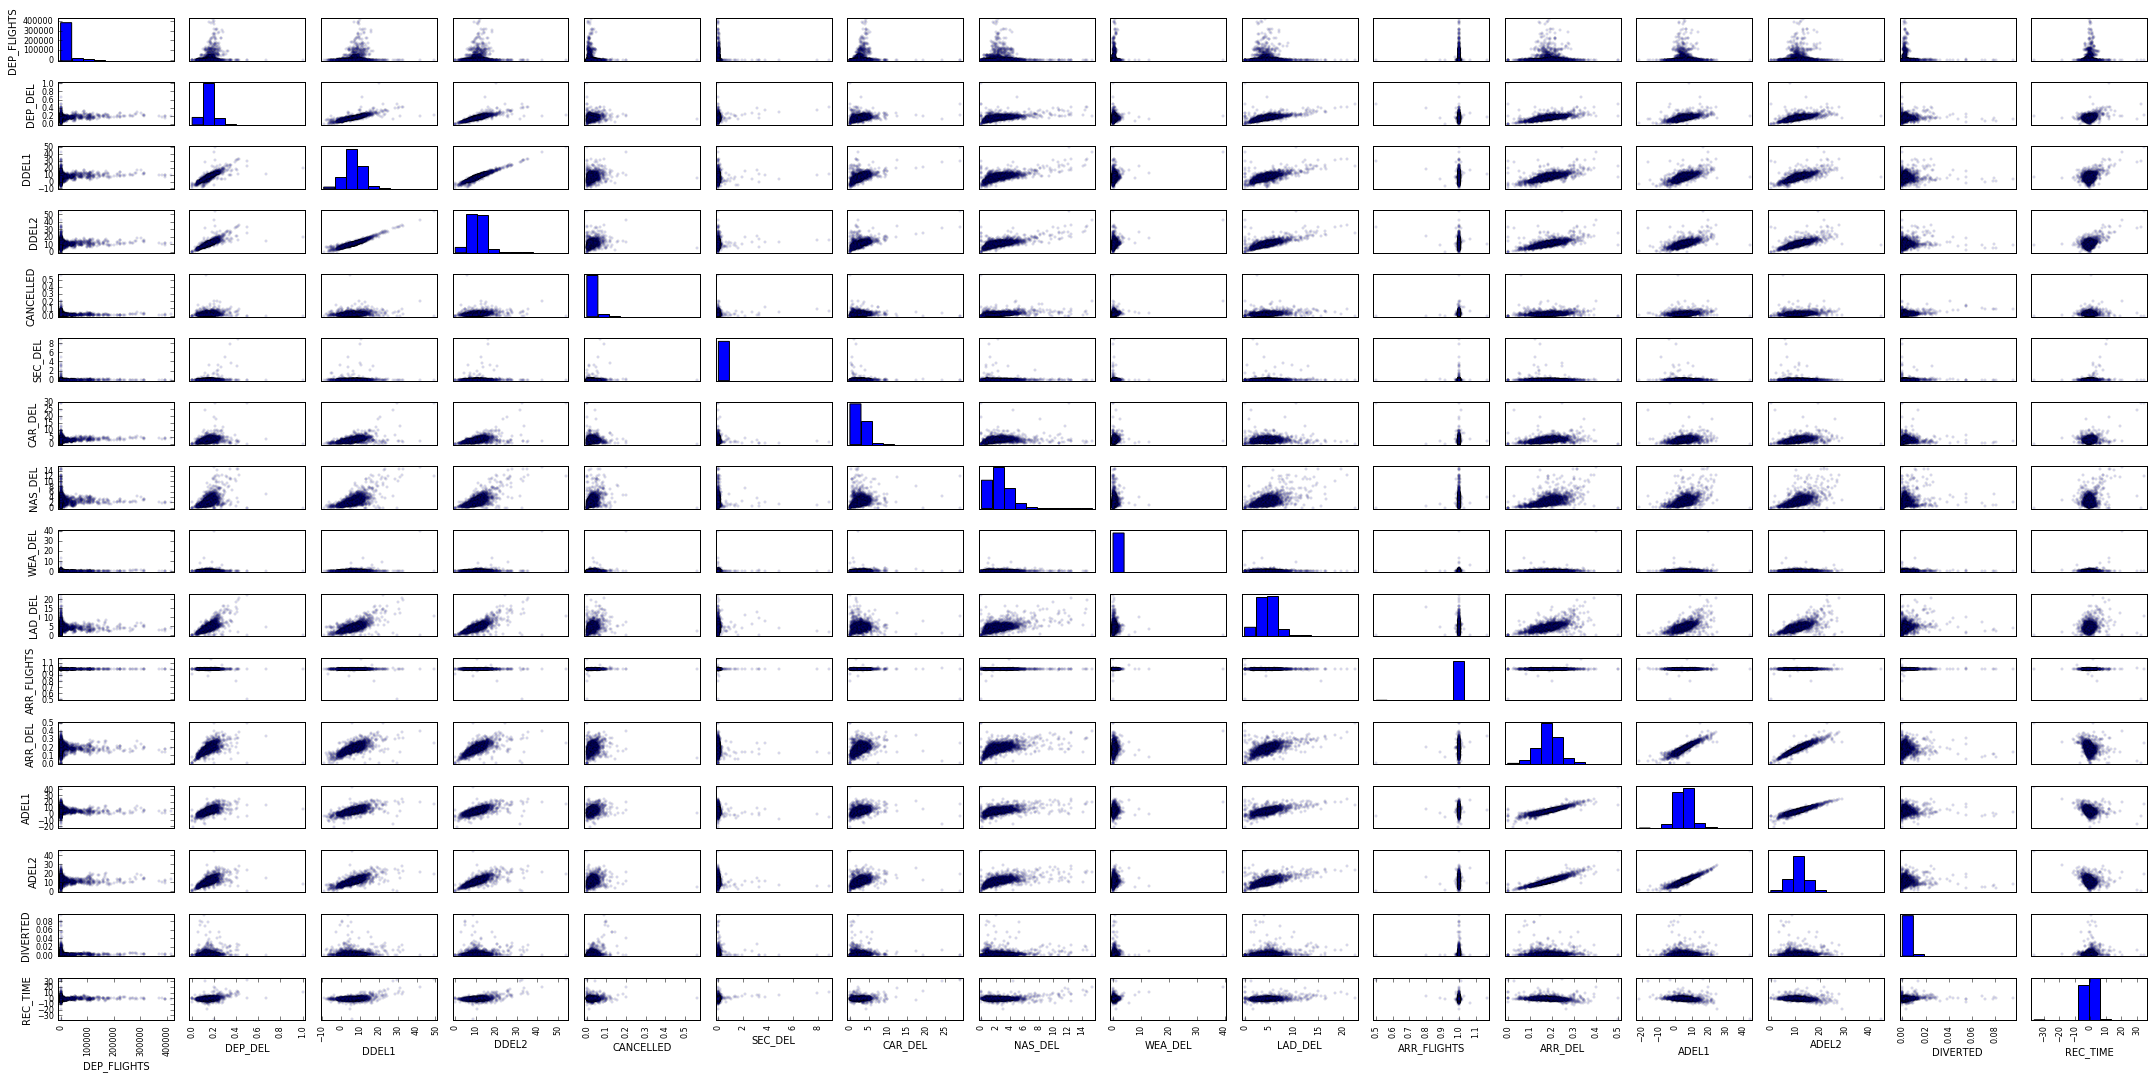

In [40]:
# a look at the correlation matrix
corr_mat = data[numeric_features].corr()
fig,ax = plt.subplots(1,1,figsize = [12,12])
plt.imshow(corr_mat)
plt.xticks(range(corr_mat.shape[0]),corr_mat.columns,rotation = 'vertical')
plt.yticks(range(corr_mat.shape[0]),corr_mat.columns)
plt.colorbar()
plt.savefig('corr_flights2.eps',format='eps')
plt.show()

fig,ax = plt.subplots(1,1,figsize = [30,15])
pd.tools.plotting.scatter_matrix(data[numeric_features], alpha=0.1,ax=ax)
plt.tight_layout()

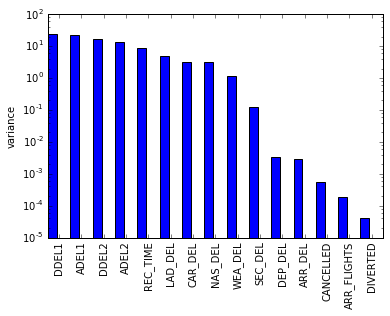

In [43]:
# filter features by degree of correlation
low_corr_features = ['DEP_FLIGHTS','DEP_DEL','CANCELLED','SEC_DEL','CAR_DEL','NAS_DEL','WEA_DEL','LAD_DEL',
                     'ARR_FLIGHTS','ARR_DEL','DIVERTED','REC_TIME']
hig_corr_features = ['DDEL1','DDEL2','ADEL1','ADEL2']

# variance analysis
var_mat = pd.DataFrame(data[features_norm].var(),columns=['variance'])
var_mat = var_mat.sort_values('variance',ascending=False)
plt.bar(np.arange(var_mat.shape[0])*2,var_mat.values)
#plt.xticks(range(0,len(numeric_features)),label=numeric_features,rotation='vertical')
plt.xticks(np.arange(len(features_norm))*2+1,var_mat.index,rotation='vertical')
plt.yscale('log')
plt.ylabel('variance')
plt.show()
# selection of important features

## Search for clustes

To optimize clusters, I will choose features with high variance and low degree of correlation. Then I will pass them to PCA. Since the selected features was renormalized using the total number of departure flights, there is no need to renormalize again. FYI, SSE for data normalized again using StandardScaler is greater by 100 that SSE with a single normalization

### Criterion 1: Non-geo
In this section, geo-coordinates are omitted

sse = 352748.42703


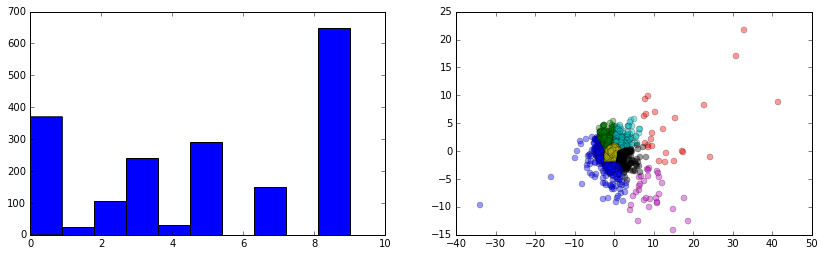

In [165]:
selected_features = ['REC_TIME','LAD_DEL','CAR_DEL','NAS_DEL','WEA_DEL','SEC_DEL']
# rescale data
#std_scaler = StandardScaler()
#resc_data = pd.DataFrame(std_scaler.fit_transform(data[selected_features]), columns = selected_features)

# reduce dimension using pca
n_components = 2
K = 10
pca = PCA(n_components=n_components)
pca_data = pd.DataFrame(pca.fit_transform(data[selected_features]),columns=range(n_components))

# generate clusters using rescaled and dimension-reduced data
kmeans1 = KMeans(K,random_state=1234)
kmeans1.fit(pca_data)

# extract centroid and labels
centroids = kmeans1.cluster_centers_
labels = kmeans1.labels_

cat_data = pca_data.copy()
cat_data['C'] = labels

#fig,ax = plt.subplots(1,2,figsize=[14,4])
#ax[0].hist(labels,bins=K)
#for c in pd.unique(cat_data.C):
#    cols = cat_data.columns.tolist()
#    ax[1].plot(cat_data[cat_data.C==c][cols[0]],cat_data[cat_data.C==c][cols[1]],'o',alpha = .4)
#plt.show()

print "sse =",calculate_sse(cat_data,centroids,labels)

# Here we use a manual touch to combine clusters with population < 40 into 1 single cluster
cat_data['C'] = cat_data.C.replace([6],1)
cat_data['C'] = cat_data.C.replace([8],3)

fig,ax = plt.subplots(1,2,figsize=[14,4])
ax[0].hist(cat_data.C,bins=K)
for c in pd.unique(cat_data.C):
    cols = cat_data.columns.tolist()
    ax[1].plot(cat_data[cat_data.C==c][cols[0]],cat_data[cat_data.C==c][cols[1]],'o',alpha = .4)
plt.show()
data['C1'] = cat_data['C']

### Criterion 2: Geo clustering

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel-4.0.3-py2.7.egg/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel-4.0.3-py2.7.egg/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


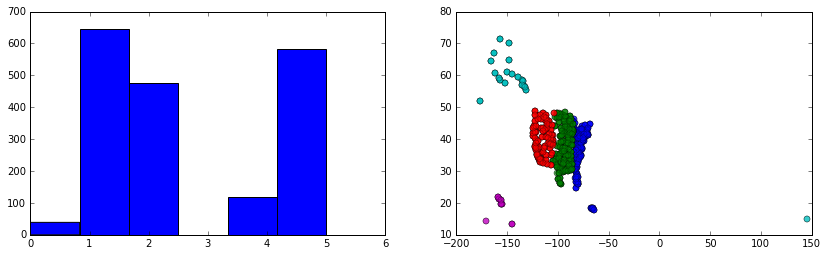

In [174]:
K = 6
kmeans2 = KMeans(K)
cat_data = data[['LAT','LON']]
kmeans2.fit(cat_data)
centroids = kmeans2.cluster_centers_
labels = kmeans2.labels_
cat_data['C'] = labels

#fig,ax = plt.subplots(1,2,figsize=[14,4])
#ax[0].hist(labels,bins=K)
#for c in pd.unique(cat_data.C):
#    cols = cat_data.columns.tolist()
#    ax[1].plot(cat_data[cat_data.C==c][cols[1]],cat_data[cat_data.C==c][cols[0]],'o',alpha = .4)
#plt.show()

# Here we use a manual touch to combine clusters with small size < 40 into 1 single cluster
cat_data['C'] = cat_data.C.replace([3],4)

fig,ax = plt.subplots(1,2,figsize=[14,4])
ax[0].hist(cat_data.C,bins=K)
for c in pd.unique(cat_data.C):
    cols = cat_data.columns.tolist()
    ax[1].plot(cat_data[cat_data.C==c][cols[1]],cat_data[cat_data.C==c][cols[0]],'o',alpha = .4)
plt.show()
data['C2'] = cat_data['C']

In [178]:
# push to dB
data.to_sql("airports_clusters",conn,index=False)